# Goal

* A basic, full run of the SIPSim pipeline with the whole bacterial genome dataset to see:
  * Does it work?
  * Does the output as each stage look OK?

# Setting variables

In [25]:
workDir = '/home/nick/notebook/SIPSim/dev/bac_genome1210/validation/'
genomeDir = '/home/nick/notebook/SIPSim/dev/bac_genome1210/genomes/'
R_dir = '/home/nick/notebook/SIPSim/lib/R/'
figureDir = '/home/nick/notebook/SIPSim/figures/'

# Init

In [26]:
import glob
from os.path import abspath
import nestly
from IPython.display import Image

In [27]:
import os
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [28]:
%%R
library(ggplot2)
library(dplyr)
library(tidyr)
library(gridExtra)

In [29]:
if not os.path.isdir(workDir):
    os.makedirs(workDir)

# Simulating fragments

In [30]:
!cd $workDir; \
    SIPSim fragments \
    $genomeDir/genome_index.txt \
    --fp $genomeDir \
    --fr ../../515F-806R.fna \
    --fld skewed-normal,9000,2500,-5 \
    --flr None,None \
    --nf 10000 \
    --np 24 \
    2> ampFrags.log \
    > ampFrags.pkl        

CPU times: user 4.48 s, sys: 498 ms, total: 4.98 s
Wall time: 25min 58s


## Number of amplicons per taxon

In [43]:
!cd $workDir; \
    grep "Number of amplicons: " ampFrags.log | \
    perl -pe 's/.+ +//' | hist


 424|   o        
 402|   o        
 380|   o        
 358|   o        
 335|   o        
 313|   o        
 291|   o        
 269|   o        
 246|   o        
 224|   o        
 202|   o        
 180|  oo o      
 157|  oooo      
 135|  oooo      
 113|  oooo      
  91|  oooo      
  68|  ooooo     
  46| ooooooo    
  24| ooooooo    
   2| ooooooooooo
     -----------

------------------------------
|          Summary           |
------------------------------
|     observations: 1210     |
|    min value: 0.000000     |
|      mean : 3.646281       |
|    max value: 16.000000    |
------------------------------


# Converting fragments to kde object

In [45]:
!cd $workDir; \
    SIPSim fragment_KDE \
    ampFrags.pkl \
    > ampFrags_kde.pkl

## Checking ampfrag info

In [46]:
!cd $workDir; \
    SIPSim KDE_info -s ampFrags_kde.pkl \
    > ampFrags_kde_info.txt

Loading KDEs...


In [65]:
%%R -i workDir -w 600 -h 300

# loading
inFile = file.path(workDir, 'ampFrags_kde_info.txt')
df = read.delim(inFile, sep='\t')
df.kde1 = df %>%
    filter(KDE_ID == 1)
df.kde1 %>% head(n=3)

BD_GC50 = 0.098 * 0.5 + 1.66

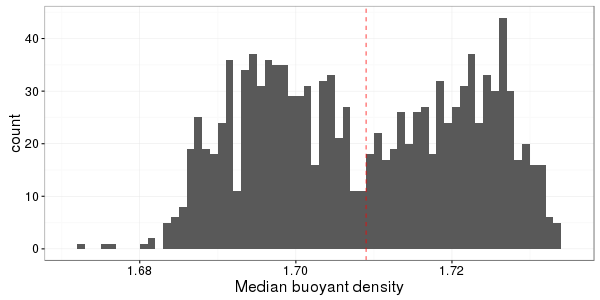

In [70]:
%%R -w 600 -h 300
# plotting
p.amp = ggplot(df.kde1, aes(median)) +
    geom_histogram(binwidth=0.001) +
    geom_vline(xintercept=BD_GC50, linetype='dashed', color='red', alpha=0.7) +
    labs(x='Median buoyant density') +
    theme_bw() +
    theme(
        text = element_text(size=16)
    )
p.amp

## check of metagenome fragment GC 

* GC of amplicon fragments should be much more bi-modal

In [60]:
!cd $workDir; \
    SIPSim fragments \
    $genomeDir/genome_index.txt \
    --fp $genomeDir \
    --fld skewed-normal,9000,2500,-5 \
    --flr None,None \
    --nf 10000 \
    --np 24 \
    > shotFrags.pkl \
    2> shotFrags.log

In [61]:
!cd $workDir; \
    SIPSim fragment_KDE \
    shotFrags.pkl \
    > shotFrags_kde.pkl

In [62]:
!cd $workDir; \
    SIPSim KDE_info -s shotFrags_kde.pkl \
    > shotFrags_kde_info.txt

Loading KDEs...


In [67]:
%%R -i workDir -w 600 -h 300

# loading
inFile = file.path(workDir, 'shotFrags_kde_info.txt')
df = read.delim(inFile, sep='\t')
df.kde1 = df %>%
    filter(KDE_ID == 1)
df.kde1 %>% head(n=3)

BD_GC50 = 0.098 * 0.5 + 1.66

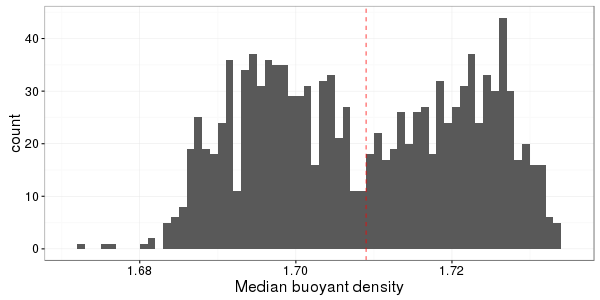

In [71]:
%%R -w 600 -h 300
# plotting
p.shot = ggplot(df.kde1, aes(median)) +
    geom_histogram(binwidth=0.001) +
    geom_vline(xintercept=BD_GC50, linetype='dashed', color='red', alpha=0.7) +
    labs(x='Median buoyant density') +
    theme_bw() +
    theme(
        text = element_text(size=16)
    )
p.shot

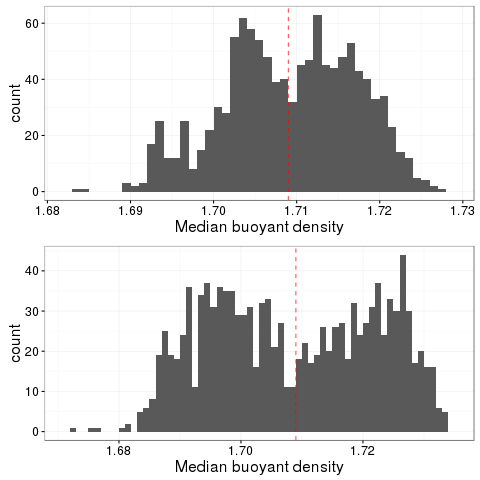

In [69]:
%%R
grid.arrange(p.amp, p.shot, ncol=1)

## NOTE:

* as expected, shotgun fragments are more bin-modal and deviating from 50% GC

# Adding diffusion

In [73]:
!cd $workDir; \
    SIPSim diffusion \
    ampFrags_kde.pkl \
    --np 24 \
    > ampFrags_kde_dif.pkl \
    2> ampFrags_kde_dif.log

# Creating a community file

In [74]:
!cd $workDir; \
    SIPSim communities \
    $genomeDir/genome_index.txt \
    --n_comm 2 \
    > comm.txt

## Plotting community rank abundances

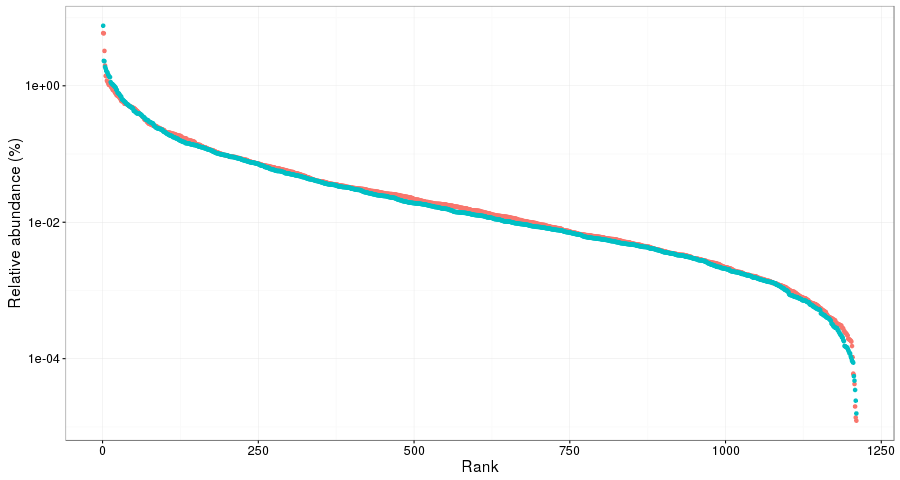

In [75]:
%%R -w 900 -i workDir

setwd(workDir)

tbl = read.delim('comm.txt', sep='\t')

tbl$library = as.character(tbl$library)

ggplot(tbl, aes(rank, rel_abund_perc, color=library, group=taxon_name)) +
    geom_point() +
    scale_y_log10() +
    labs(x='Rank', y='Relative abundance (%)') +
    theme_bw() +
    theme(
        text=element_text(size=16),
        legend.position='none'
        )

#### Notes:

* Colors = pre-fractionation communities

# Making an incorp config file

In [76]:
%time !cd $workDir; \
    SIPSim incorpConfigExample \
    --percTaxa 10 \
    --percIncorpUnif 100 \
    > PT10_PI100.config

CPU times: user 2.37 ms, sys: 4.49 ms, total: 6.86 ms
Wall time: 1.01 s


# Adding isotope incorporation to BD distribution

In [79]:
!cd $workDir; \
    SIPSim isotope_incorp \
    ampFrags_kde_dif.pkl \
    PT10_PI100.config \
    --comm comm.txt \
    --np 24 \
    > ampFrags_kde_dif_incorp.pkl \
    2> ampFrags_kde_dif_incorp.log

# Calculating BD shift from isotope incorporation

In [78]:
!cd $workDir; \
    SIPSim BD_shift \
    ampFrags_kde_dif.pkl \
    ampFrags_kde_dif_incorp.pkl \
    --np 30 \
    > ampFrags_kde_dif_incorp_BD-shift.txt

Loading KDE objects...
Calculating BD shifts...
  Comparing libraries; "NA", "1"
  Processing: Vibrio_vulnificus_MO6-24_O
  Processing: Robiginitalea_biformata_HTCC2501
  Processing: Xanthobacter_autotrophicus_Py2
  Processing: Rickettsia_conorii_str_Malish_7
  Processing: Mycobacterium_vanbaalenii_PYR-1
  Processing: Capnocytophaga_canimorsus_Cc5
  Processing: Haemophilus_somnus_129PT
  Processing: Candidatus_Kinetoplastibacterium_oncopeltii_TCC290E
  Processing: Mannheimia_succiniciproducens_MBEL55E
  Processing: Acidiphilium_cryptum_JF-5
  Processing: Raoultella_ornithinolytica_B6
  Processing: Nitrosococcus_watsonii_C-113
  Processing: Desulfovibrio_salexigens_DSM_2638
  Processing: Bradyrhizobium_japonicum_USDA_6
  Processing: Sphaerobacter_thermophilus_DSM_20745
  Processing: Elusimicrobium_minutum_Pei191
  Processing: Gloeobacter_violaceus_PCC_7421
  Processing: Alkaliphilus_oremlandii_OhILAs
  Processing: Candidatus_Hodgkinia_cicadicola_Dsem
  Processing: Nakamurella_multiparti

## Plotting BD-shift

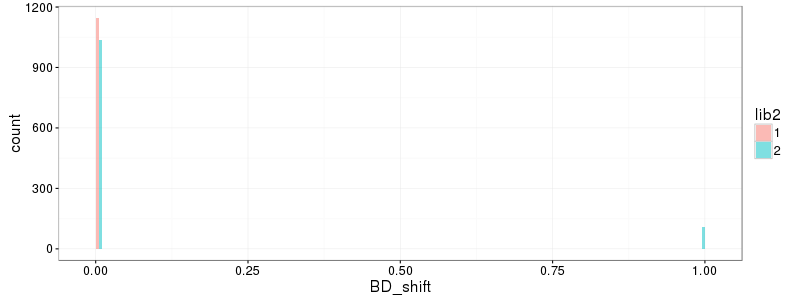

In [80]:
%%R -i workDir -w 800 -h 300

setwd(workDir)

tbl = read.csv('ampFrags_kde_dif_incorp_BD-shift.txt', sep='\t')

tbl$lib2 = as.character(tbl$lib2)
ggplot(tbl, aes(BD_shift, fill=lib2)) +
    geom_histogram(position='dodge', alpha=0.5, binwidth=0.01) +
    theme_bw() +
    theme(
        text = element_text(size=16)
        )

# Simulating gradient fractions

In [81]:
!cd $workDir; \
    SIPSim gradient_fractions \
    comm.txt \
    > fracs.txt

## Plotting fractions

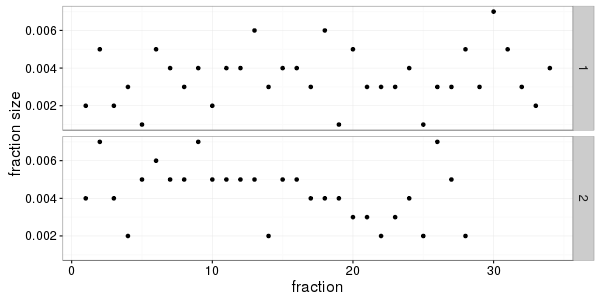

In [82]:
%%R -i workDir -w 600 -h 300
setwd(workDir)

tbl = read.delim('fracs.txt', sep='\t')

ggplot(tbl, aes(fraction, fraction_size)) +
    geom_point() +
    facet_grid(library ~ .) +
    labs(y='fraction size') +
    theme_bw() +
    theme(
        text=element_text(size=16)
        )

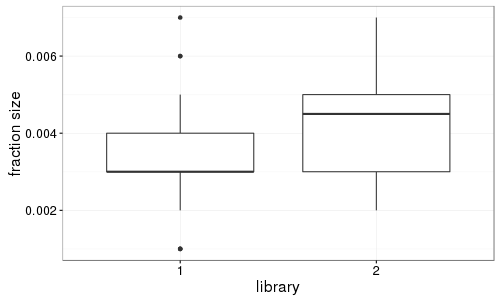

In [83]:
%%R -w 500 -h 300
tbl$library = as.character(tbl$library)

ggplot(tbl, aes(library, fraction_size)) +
    geom_boxplot() +
    labs(y='fraction size') +
    theme_bw() +
    theme(
        text=element_text(size=16)
        )

# Simulating an OTU table

In [84]:
!cd $workDir; \
    SIPSim OTU_table \
    ampFrags_kde_dif_incorp.pkl \
    comm.txt \
    fracs.txt \
    --abs 1e9 \
    --np 24 \
    > OTU_abs1e9.txt \
    2> OTU_abs1e9.log \

## Plotting taxon abundances

In [85]:
%%R -i workDir
setwd(workDir)

# loading file
tbl = read.delim('OTU_abs1e9.txt', sep='\t')

#tbl = tbl %>% 
#    filter(!grepl('inf', fraction, ignore.case=T)) #%>%
    #separate(fraction, into = c('BD_min','BD_max'), sep='-', convert=TRUE) %>%
   #filter(BD_min != 1.795)

In [86]:
%%R
## BD for G+C of 0 or 100
BD.GCp0 = 0 * 0.098 + 1.66
BD.GCp100 = 1 * 0.098 + 1.66

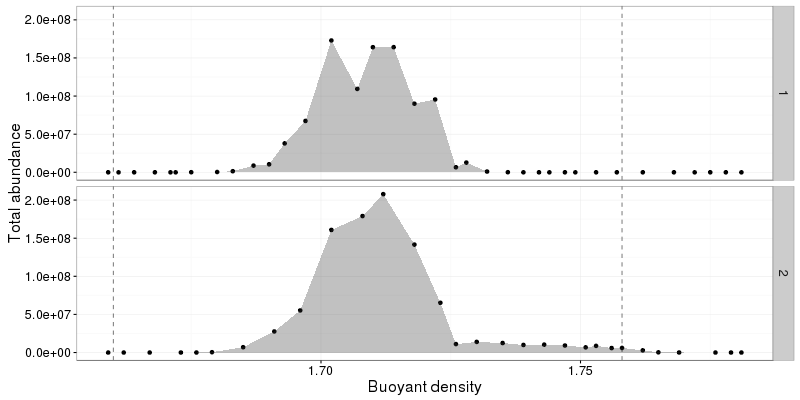

In [87]:
%%R -w 800 -h 400
# plotting absolute abundances

tbl.s = tbl %>%
    group_by(library, BD_mid) %>%
    summarize(total_count = sum(count))

## plot
p = ggplot(tbl.s, aes(BD_mid, total_count)) +
    geom_point() +
    geom_area(stat='identity', alpha=0.3, position='dodge') +
    geom_vline(xintercept=c(BD.GCp0, BD.GCp100), linetype='dashed', alpha=0.5) +
    labs(x='Buoyant density', y='Total abundance') +
    facet_grid(library ~ .) +
    theme_bw() +
    theme( 
        text = element_text(size=16) 
    )
p

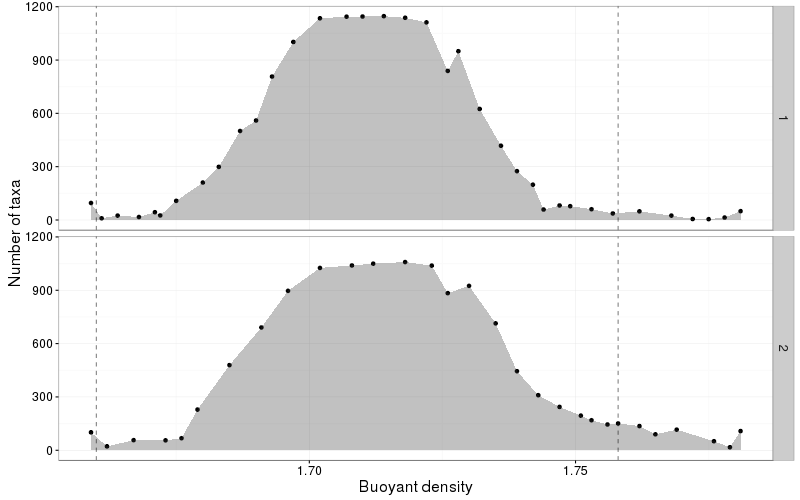

In [95]:
%%R -w 800 -h 500
# plotting number of taxa at each BD

tbl.nt = tbl %>%
    filter(count > 0) %>%
    group_by(library, BD_mid) %>%
    summarize(n_taxa = n())

## plot
p = ggplot(tbl.nt, aes(BD_mid, n_taxa)) +
    geom_point() +
    geom_area(stat='identity', alpha=0.3, position='dodge') +
    #geom_histogram(stat='identity') +
    geom_vline(xintercept=c(BD.GCp0, BD.GCp100), linetype='dashed', alpha=0.5) +
    labs(x='Buoyant density', y='Number of taxa') +
    facet_grid(library ~ .) +
    theme_bw() +
    theme( 
        text = element_text(size=16),
        legend.position = 'none'
    )
p

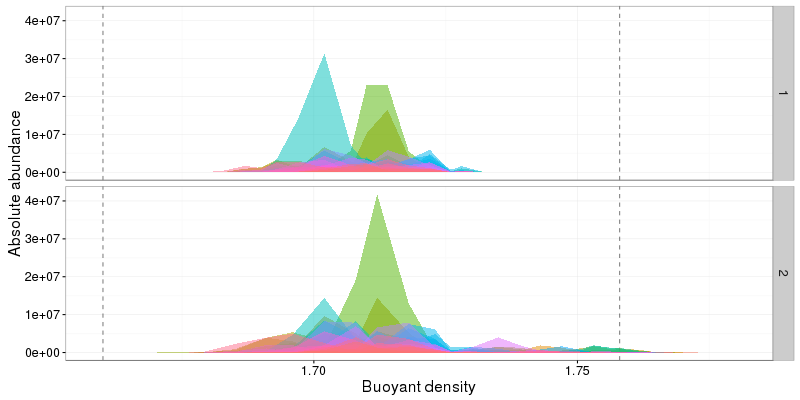

In [96]:
%%R -w 800 -h 400
# plotting relative abundances

## plot
p = ggplot(tbl, aes(BD_mid, count, fill=taxon)) +
    geom_vline(xintercept=c(BD.GCp0, BD.GCp100), linetype='dashed', alpha=0.5) +
    labs(x='Buoyant density', y='Absolute abundance') +
    facet_grid(library ~ .) +
    theme_bw() +
    theme( 
        text = element_text(size=16),
        legend.position = 'none'
    )
p + geom_area(stat='identity', position='dodge', alpha=0.5)

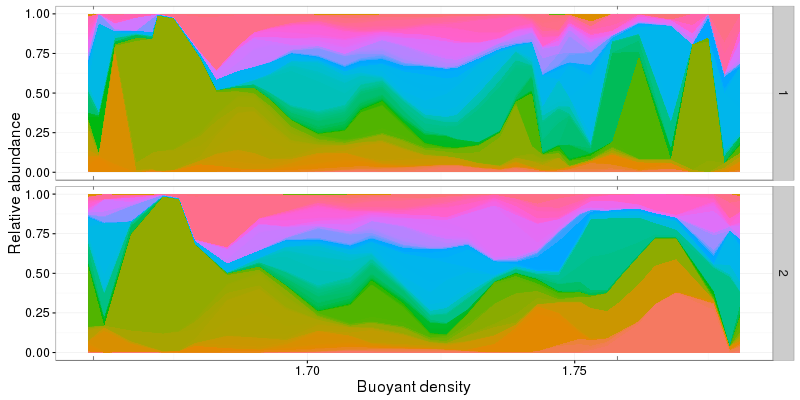

In [97]:
%%R -w 800 -h 400
p + 
    geom_area(stat='identity', position='fill') +
    labs(x='Buoyant density', y='Relative abundance')

# Subsampling from the OTU table 

* simulating sequencing of the DNA pool

In [100]:
!cd $workDir; \
    SIPSim OTU_subsample \
    --dist normal \
    --dist_params loc:30000,scale:5000 \
    OTU_abs1e9.txt \
    > OTU_n2_abs1e9_subNorm.txt

Traceback (most recent call last):
  File "/home/nick/notebook/SIPSim/bin/OTU_subsample.py", line 104, in <module>
    main(Uargs)
  File "/home/nick/notebook/SIPSim/bin/OTU_subsample.py", line 95, in main
    base=Uargs['--base'])
  File "/home/nick/notebook/SIPSim/bin/../lib/OTU_Table.py", line 473, in subsample
    samp_size = samp_sizes[samp_cnt]
IndexError: list index out of range


### Testing/Plotting seq count distribution

In [92]:
%%R -h 300
setwd(workDir)

tbl = read.csv('OTU_n2_abs1e9_subNorm.txt', sep='\t')

tbl.s = tbl %>% 
    group_by(library, fraction) %>%
    summarize(total_count = sum(count)) %>%
    ungroup() %>%
    mutate(library = as.character(library))

ggplot(tbl.s, aes(library, total_count)) +
    geom_boxplot()


Error in read.table(file = file, header = header, sep = sep, quote = quote,  : 
  no lines available in input


/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Warning message:

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Width not defined. Set with `position_dodge(width = ?)` 

  res = super(Function, self).__call__(*new_args, **new_kwargs)


# Plotting abundance distributions (paper figure)

In [93]:
%%R -i workDir

setwd(workDir)

# loading file
tbl.abs = read.delim('OTU_abs1e9.txt', sep='\t')
tbl.sub = read.delim('OTU_n2_abs1e9_subNorm.txt', sep='\t')

lib.reval = c('1' = 'control',
              '2' = 'treatment')

tbl.abs = mutate(tbl.abs, library = plyr::revalue(as.character(library), lib.reval))
tbl.sub = mutate(tbl.sub, library = plyr::revalue(as.character(library), lib.reval))


Error in read.table(file = file, header = header, sep = sep, quote = quote,  : 
  no lines available in input


In [94]:
%%R -w 700 -h 800
# plotting absolute abundances
## plot
p = ggplot(tbl.abs, aes(BD_mid, count, fill=taxon)) +
    geom_vline(xintercept=c(BD.GCp0, BD.GCp100), linetype='dashed', alpha=0.5) +
    labs(x='Buoyant density') +
    facet_grid(library ~ .) +
    theme_bw() +
    theme( 
        text = element_text(size=16),
        axis.title.y = element_text(vjust=1),        
        axis.title.x = element_blank(),
        legend.position = 'none',
        plot.margin=unit(c(1,1,0.1,1), "cm")
    )
p1 = p + geom_area(stat='identity', position='dodge', alpha=0.5) +
    labs(y='Total community\n(absolute abundance)')

# plotting absolute abundances of subsampled
## plot
p = ggplot(tbl.sub, aes(BD_mid, count, fill=taxon)) +
    geom_vline(xintercept=c(BD.GCp0, BD.GCp100), linetype='dashed', alpha=0.5) +
    labs(x='Buoyant density') +
    facet_grid(library ~ .) +
    theme_bw() +
    theme( 
        text = element_text(size=16),
        legend.position = 'none'
    )
p2 = p + geom_area(stat='identity', position='dodge', alpha=0.5) +
    labs(y='Subsampled community\n(absolute abundance)') +
    theme(
          axis.title.y = element_text(vjust=1),        
          axis.title.x = element_blank(),
          plot.margin=unit(c(0.1,1,0.1,1), "cm")
         )

# plotting relative abundances of subsampled
p3 = p + geom_area(stat='identity', position='fill') +
    geom_vline(xintercept=c(BD.GCp0, BD.GCp100), linetype='dashed', alpha=0.5) +
    labs(y='Subsampled community\n(relative abundance)') +
    theme(
          axis.title.y = element_text(vjust=1),
          plot.margin=unit(c(0.1,1,1,1.35), "cm")
        )

# combining plots
grid.arrange(p1, p2, p3, ncol=1)


Error in ggplot(tbl.sub, aes(BD_mid, count, fill = taxon)) : 
  object 'tbl.sub' not found


/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Error in ggplot(tbl.sub, aes(BD_mid, count, fill = taxon)) : 
  object 'tbl.sub' not found

  res = super(Function, self).__call__(*new_args, **new_kwargs)


In [30]:
%%R -i figureDir 
# saving figure

outFile = paste(c(figureDir, 'abundDist_example.pdf'), collapse='/')

pdf(outFile, width=10.5, height=12)
grid.arrange(p1, p2, p3, ncol=1)
dev.off()

png 
  2 


# Making a wide OTU table

In [31]:
%time !cd $workDir; \
    SIPSim OTU_wideLong -w \
    OTU_n2_abs1e9_subNorm.txt \
    > OTU_n2_abs1e9_subNorm_w.txt

CPU times: user 4 ms, sys: 8 ms, total: 12 ms
Wall time: 1.2 s


# Making metadata (phyloseq: sample_data)

In [32]:
%time !cd $workDir; \
    SIPSim OTU_sampleData \
    OTU_n2_abs1e9_subNorm.txt \
    > OTU_n2_abs1e9_subNorm_meta.txt

CPU times: user 8 ms, sys: 8 ms, total: 16 ms
Wall time: 1.19 s


# Community analysis

## Phyloseq

In [33]:
%%bash -s $workDir
cd $1

export PATH=/home/nick/notebook/SIPSim/lib/R/:$PATH

# making phyloseq object from OTU table
phyloseq_make.r \
    OTU_n2_abs1e9_subNorm_w.txt \
    -s OTU_n2_abs1e9_subNorm_meta.txt \
    > OTU_n2_abs1e9_subNorm.physeq
## making ordination
phyloseq_ordination.r \
    OTU_n2_abs1e9_subNorm.physeq \
    OTU_n2_abs1e9_subNorm_bray-NMDS.pdf    
## filtering phyloseq object to just taxa/samples of interest
phyloseq_edit.r \
    OTU_n2_abs1e9_subNorm.physeq \
    --BD_min 1.71 --BD_max 1.75 --occur 0.25 \
    > OTU_n2_abs1e9_subNorm_filt.physeq
## making ordination
phyloseq_ordination.r \
    OTU_n2_abs1e9_subNorm_filt.physeq \
    OTU_n2_abs1e9_subNorm_filt_bray-NMDS.pdf
    
convert OTU_n2_abs1e9_subNorm_bray-NMDS.pdf OTU_n2_abs1e9_subNorm_bray-NMDS.png
convert OTU_n2_abs1e9_subNorm_filt_bray-NMDS.pdf OTU_n2_abs1e9_subNorm_filt_bray-NMDS.png

Square root transformation
Wisconsin double standardization
Run 0 stress 0.164463 
Run 1 stress 0.1642927 
... New best solution
... procrustes: rmse 0.08276225  max resid 0.4039917 
Run 2 stress 0.1690229 
Run 3 stress 0.1546802 
... New best solution
... procrustes: rmse 0.07356103  max resid 0.4316371 
Run 4 stress 0.1705385 
Run 5 stress 0.1834644 
Run 6 stress 0.164404 
Run 7 stress 0.1795747 
Run 8 stress 0.1599368 
Run 9 stress 0.1719771 
Run 10 stress 0.1679711 
Run 11 stress 0.1681683 
Run 12 stress 0.1679867 
Run 13 stress 0.1625577 
Run 14 stress 0.1697082 
Run 15 stress 0.1795697 
Run 16 stress 0.1758487 
Run 17 stress 0.1651887 
Run 18 stress 0.1636719 
Run 19 stress 0.165994 
Run 20 stress 0.1642875 
Square root transformation
Wisconsin double standardization
Run 0 stress 0.06783975 
Run 1 stress 0.06783961 
... New best solution
... procrustes: rmse 5.4394e-05  max resid 0.0001729409 
*** Solution reached


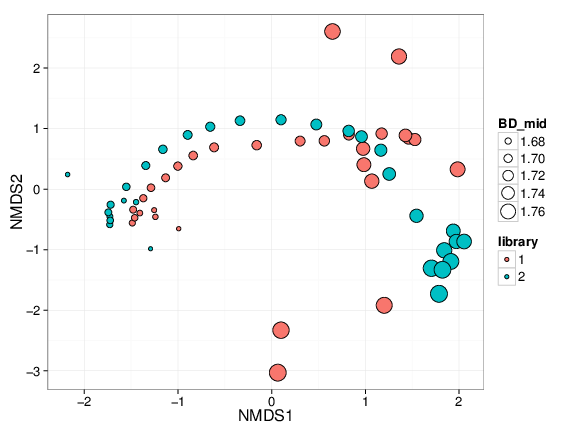

In [34]:
os.chdir(workDir)
Image(filename='OTU_n2_abs1e9_subNorm_bray-NMDS.png') 

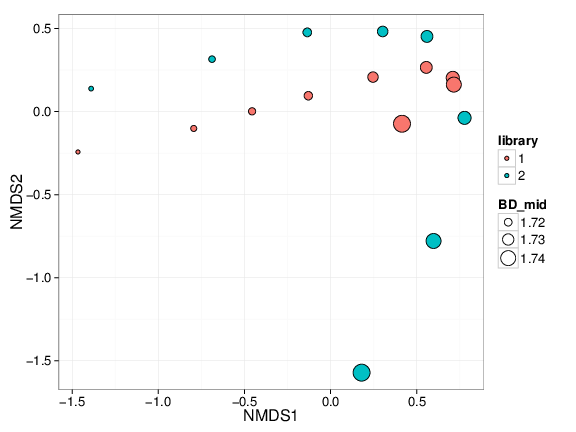

In [35]:
os.chdir(workDir)
Image(filename='OTU_n2_abs1e9_subNorm_filt_bray-NMDS.png')

## DESeq2

In [36]:
%%bash -s $workDir
cd $1

export PATH=/home/nick/notebook/SIPSim/lib/R/:$PATH

# Chuck's method

## DESeq2
phyloseq_DESeq2.r \
    OTU_n2_abs1e9_subNorm_filt.physeq \
    --log2 0.25 \
    > OTU_n2_abs1e9_subNorm_DESeq2
## Confusion matrix
DESeq2_confuseMtx.r \
    ampFrags_kde_dif_incorp_BD-shift.txt \
    OTU_n2_abs1e9_subNorm_DESeq2 \
    --padjBH 0.1

converting counts to integer mode
Warning message:
In DESeqDataSet(se, design = design, ignoreRank) :
  some variables in design formula are characters, converting to factors
using pre-existing size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing
-- replacing outliers and refitting for 66 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)
estimating dispersions
fitting model and testing
Log2Fold cutoff: -Inf
padj cutoff: 0.1
File written: DESeq2-cMtx_data.csv
File written: DESeq2-cMtx
File written: DESeq2-cMtx_table.csv
File written: DESeq2-cMtx_overall.csv
File written: DESeq2-cMtx_byClass.csv


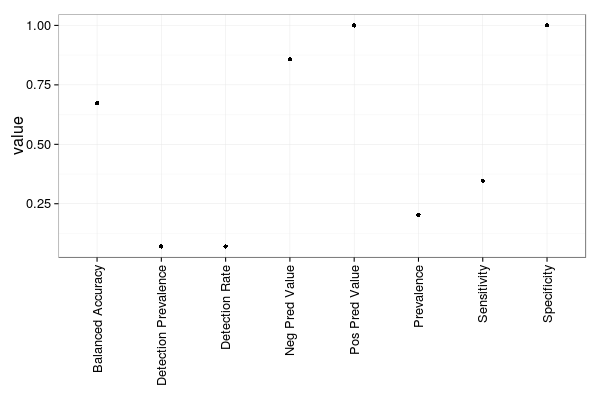

In [37]:
%%R -i workDir -w 600 -h 400

setwd(workDir)

byClass = read.csv('DESeq2-cMtx_byClass.csv')

ggplot(byClass, aes(X, byClass)) +
    geom_point() +
    labs(y='value') +
    theme_bw() +
    theme(
        text=element_text(size=16),
        axis.text.x=element_text(angle=90, hjust=1, vjust=0.5),
        axis.title.x=element_blank()
        )

In [38]:
%%bash -s $workDir
cd $1

export PATH=/home/nick/notebook/SIPSim/lib/R/:$PATH

# altHypothesis = 'greater'

## DESeq2
phyloseq_DESeq2.r \
    OTU_n2_abs1e9_subNorm_filt.physeq \
    --log2 0.25 \
    --hypo greater \
    > OTU_n2_abs1e9_subNorm_DESeq2
    
## Confusion matrix
DESeq2_confuseMtx.r \
    ampFrags_kde_dif_incorp_BD-shift.txt \
    OTU_n2_abs1e9_subNorm_DESeq2 \
    --padj 0.1    

converting counts to integer mode
Warning message:
In DESeqDataSet(se, design = design, ignoreRank) :
  some variables in design formula are characters, converting to factors
using pre-existing size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing
-- replacing outliers and refitting for 66 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)
estimating dispersions
fitting model and testing
Log2Fold cutoff: -Inf
padj cutoff: 0.1
File written: DESeq2-cMtx_data.csv
File written: DESeq2-cMtx
File written: DESeq2-cMtx_table.csv
File written: DESeq2-cMtx_overall.csv
File written: DESeq2-cMtx_byClass.csv


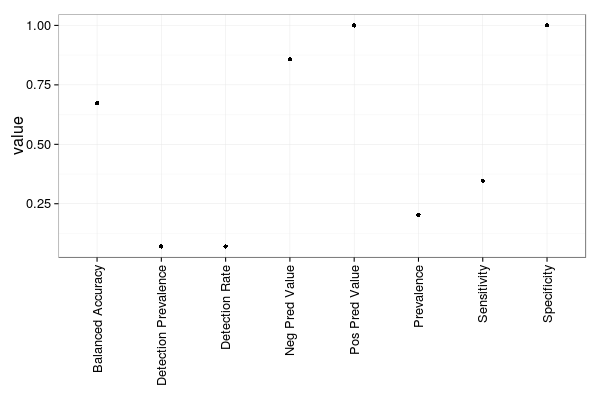

In [39]:
%%R -i workDir -w 600 -h 400

setwd(workDir)

byClass = read.csv('DESeq2-cMtx_byClass.csv')

ggplot(byClass, aes(X, byClass)) +
    geom_point() +
    labs(y='value') +
    theme_bw() +
    theme(
        text=element_text(size=16),
        axis.text.x=element_text(angle=90, hjust=1, vjust=0.5),
        axis.title.x=element_blank()
        )

# Conclusions


* BD_shift and OTU_table are memory intensive & must use less cores
* DESeq2 sensitivity is low, but specificity is perfect

## Plotting results of DESeq2

In [40]:
%%R

clsfy = function(guess,known){
    if(is.na(guess) | is.na(known)){
        return(NA)
        }
    if(guess == TRUE){
        if(guess == known){
            return('True positive')
            } else {
            return('False positive')
            }
        } else
    if(guess == FALSE){
        if(guess == known){
            return('True negative')
            } else {
            return('False negative')
            }
        } else {
        stop('Error: true or false needed')
        }
    }

In [41]:
%%R -i workDir -w 1000 -h 450
setwd(workDir)

tbl = read.csv('DESeq2-cMtx_data.csv')

tbl = tbl %>%
    filter(! is.na(log2FoldChange)) %>%
    mutate(taxon = reorder(taxon, -log2FoldChange),
           cls = mapply(clsfy, incorp.pred, incorp.known))

tbl %>% head

  lib1 lib2                                    taxon BD_shift    baseMean
1   NA    2               Vibrio_vulnificus_MO6-24_O        0  0.65505385
2   NA    2 Staphylococcus_aureus_subsp_aureus_T0131        0  0.06054251
3   NA    2         Robiginitalea_biformata_HTCC2501        0  6.81889890
4   NA    2                 Leuconostoc_citreum_KM20        0  0.11107173
5   NA    2    Klebsiella_pneumoniae_30660_NJST258_1        0  9.48822480
6   NA    2               Sphingomonas_wittichii_RW1        0 62.45879200
  log2FoldChange    lfcSE stat    pvalue      padj         p   padj.BH
1    -1.24223315 2.376838    0 0.7349400 0.9725503 0.7349400 0.9725503
2    -2.16668520 2.571053    0 0.8263808 0.9725503 0.8263808 0.9725503
3    -0.09288998 1.676576    0 0.5810256 0.9725503 0.5810256 0.9725503
4    -0.14662442 2.472815    0 0.5637146 0.9725503 0.5637146 0.9725503
5    -0.05612312 1.376433    0 0.5880000 0.9725503 0.5880000 0.9725503
6    -0.28029850 1.073324    0 0.6893720 0.9725503 0.689

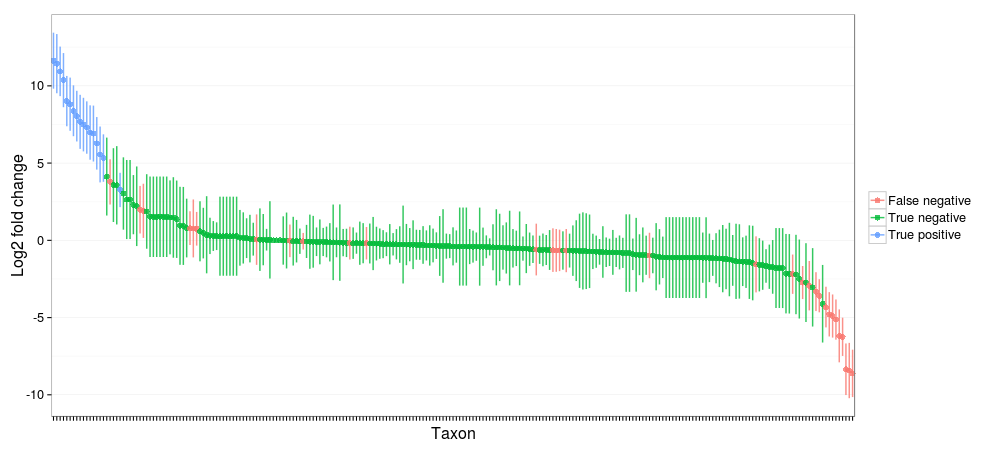

In [42]:
%%R -w 1000 -h 450

ggplot(tbl, aes(taxon, log2FoldChange, color=cls, ymin=log2FoldChange - lfcSE, ymax=log2FoldChange + lfcSE)) +
    geom_pointrange(size=0.7, alpha=0.8) +
    labs(x = 'Taxon', y = 'Log2 fold change') +
    theme_bw() +
    theme(
        text = element_text(size=16),
        panel.grid.major.x = element_blank(),
        panel.grid.minor.x = element_blank(),        
        legend.title=element_blank(),
        axis.text.x = element_blank()
        )

In [43]:
%%R -i figureDir

outFile = paste(c(figureDir, 'l2fc_example.pdf'), collapse='/')
ggsave(outFile, width=10, height=4.5)

__Notes:__

* Red circles = true positives

* False positives should increase with taxon GC 
  * Higher GC moves 100% incorporators too far to the right the gradient for the 'heavy' BD range of 1.71-1.75

# Plotting abundance distribution of True Positive taxa (actual incorporators) 

In [44]:
%%R -i workDir -w 1000 -h 450
setwd(workDir)

tbl.ds = read.csv('DESeq2-cMtx_data.csv')

# loading file
tbl.otu = read.delim('OTU_abs1e9.txt', sep='\t')

tbl.j = inner_join(tbl.otu, tbl.ds, c('taxon' = 'taxon'))

# edit
lib.reval = c('1' = 'control',
              '2' = 'treatment')

tbl.j = mutate(tbl.j, library = plyr::revalue(as.character(library), lib.reval))

tbl.j %>% head

  library                                taxon    fraction BD_min BD_mid BD_max
1 control Acetobacter_pasteurianus_IFO_3283-12  -inf-1.660   -Inf  1.660  1.660
2 control Acetobacter_pasteurianus_IFO_3283-12 1.660-1.666  1.660  1.663  1.666
3 control Acetobacter_pasteurianus_IFO_3283-12 1.666-1.672  1.666  1.669  1.672
4 control Acetobacter_pasteurianus_IFO_3283-12 1.672-1.674  1.672  1.673  1.674
5 control Acetobacter_pasteurianus_IFO_3283-12 1.674-1.677  1.674  1.675  1.677
6 control Acetobacter_pasteurianus_IFO_3283-12 1.677-1.681  1.677  1.679  1.681
  count lib1 lib2 BD_shift baseMean log2FoldChange    lfcSE stat    pvalue
1     0   NA    2        0 14.90592      -1.065787 1.792833    0 0.7684997
2     0   NA    2        0 14.90592      -1.065787 1.792833    0 0.7684997
3     0   NA    2        0 14.90592      -1.065787 1.792833    0 0.7684997
4     0   NA    2        0 14.90592      -1.065787 1.792833    0 0.7684997
5     0   NA    2        0 14.90592      -1.065787 1.792833    0 

In [45]:
%%R
# DESeq2 params
BD.win.min = 1.71
BD.win.max = 1.75

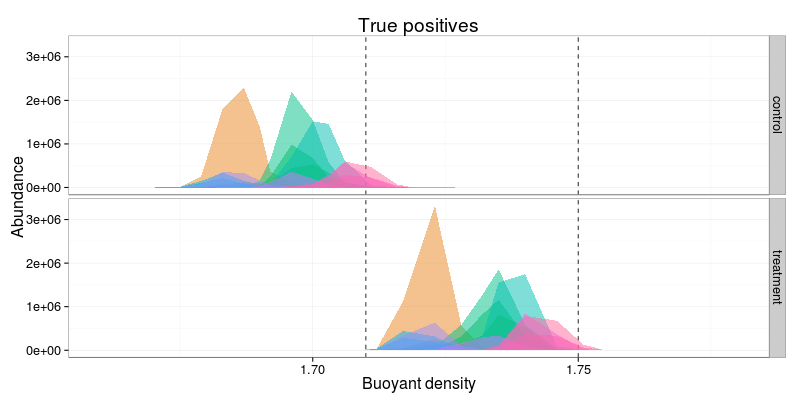

In [46]:
%%R -w 800 -h 400
# plotting absolute abundances

tbl.j.TP = tbl.j %>% 
    filter(incorp.known == TRUE & incorp.pred == TRUE) 


## plot
p = ggplot(tbl.j.TP, aes(BD_mid, count, fill=taxon)) +
    geom_vline(xintercept=c(BD.win.min, BD.win.max), linetype='dashed', alpha=0.8) +
    labs(x='Buoyant density', y='Abundance', title='True positives') +
    facet_grid(library ~ .) +
    theme_bw() +
    theme( 
        text = element_text(size=16),
        legend.position = 'none'
    )
p1 = p + geom_area(stat='identity', position='dodge', alpha=0.5)
p1

# Plotting abundance distribution of False Negative taxa (actual incorporators) 

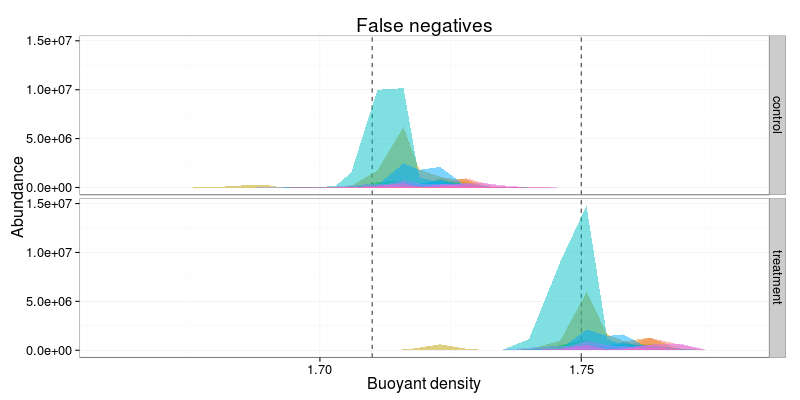

In [47]:
%%R -w 800 -h 400
# plotting relative abundances

tbl.j.FN = tbl.j %>% 
    filter(incorp.known == TRUE & incorp.pred == FALSE) 

## plot
p = ggplot(tbl.j.FN, aes(BD_mid, count, fill=taxon)) +
    geom_vline(xintercept=c(BD.win.min, BD.win.max), linetype='dashed', alpha=0.8) +
    labs(x='Buoyant density', y='Abundance', title='False negatives') +
    facet_grid(library ~ .) +
    theme_bw() +
    theme( 
        text = element_text(size=16),
        legend.position = 'none'
    )
p2 = p + geom_area(stat='identity', position='dodge', alpha=0.5)
p2

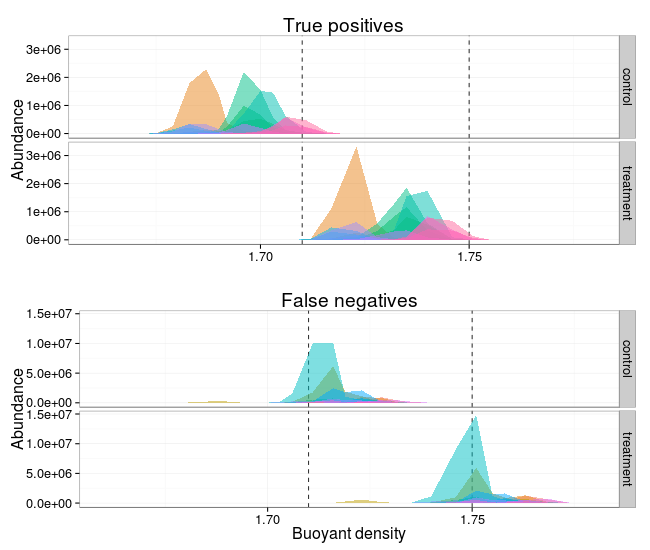

In [48]:
%%R -i figureDir -h 550 -w 650

outFile = paste(c(figureDir, 'abundDist_TP-FN_example.pdf'), collapse='/')

p1.e = p1 + theme(axis.title.x = element_blank())

pdf(outFile, width=13, height=11)
grid.arrange(p1.e, p2, ncol=1)
dev.off()

grid.arrange(p1.e, p2, ncol=1)

## Conclusions

* For 100% incorporation, the 'heavy' BD range of 1.71-1.75 does not encompass most of the incorporator abundance.
  * This results in negative log2fc

# Enrichment of TP for abundant incorporators?

* What is the abundance distribution of TP and FP?
  * Are more abundant incorporators being detected more than low abundant taxa

In [49]:
%%R -i workDir

setwd(workDir)

tbl.ds = read.csv('DESeq2-cMtx_data.csv')
tbl.otu = read.delim('OTU_abs1e9.txt', sep='\t')

In [50]:
%%R
tbl.ds %>% filter(incorp.known==TRUE & incorp.pred==FALSE)

   lib1 lib2                                                  taxon  BD_shift
1    NA    2                   Rhodospirillum_photometricum_DSM_122 0.9995309
2    NA    2                                       Dickeya_zeae_EC1 0.9984141
3    NA    2                      Roseobacter_denitrificans_OCh_114 0.9999027
4    NA    2                     Pelotomaculum_thermopropionicum_SI 0.9990932
5    NA    2                        Methylobacterium_extorquens_AM1 0.9996827
6    NA    2                              Rothia_mucilaginosa_DY-18 0.9997541
7    NA    2                  Morganella_morganii_subsp_morganii_KT 0.9991415
8    NA    2                            Pseudomonas_aeruginosa_RP73 0.9997352
9    NA    2                     Bifidobacterium_thermophilum_RBL67 0.9992636
10   NA    2                               Treponema_primitia_ZAS-2 0.9921510
11   NA    2                              Alcanivorax_dieselolei_B5 0.9995939
12   NA    2          Enterobacter_cloacae_subsp_cloacae_ATCC_13

In [51]:
%%R
# OTU total counts
tbl.otu.sum = tbl.otu %>%
    group_by(library, taxon) %>%
    summarize(total_count = sum(count))
tbl.otu.sum %>% head

Source: local data frame [6 x 3]
Groups: library

  library                                taxon total_count
1       1       Acaryochloris_marina_MBIC11017       10484
2       1       Acetobacterium_woodii_DSM_1030      760272
3       1 Acetobacter_pasteurianus_IFO_3283-12     2109667
4       1    Acetohalobium_arabaticum_DSM_5501     1116550
5       1         Acholeplasma_laidlawii_PG-8A     1038131
6       1        Achromobacter_xylosoxidans_A8       34255


In [52]:
%%R
# 
label.tp.fn = function(known, pred){
    if(is.na(known) | is.na(pred)){
        return(NA)
        } else
    if(known==TRUE & pred==TRUE){
        return('TP')
        } else
    if(known==FALSE & pred==TRUE){
        return('FN')
        } else {
        return(NA)
        }
    }

tbl.ds.tp.fn = tbl.ds %>% 
    mutate(tp.fn = mapply(label.tp.fn, incorp.known, incorp.pred)) %>%
    filter(! is.na(tp.fn))

tbl.tp.fn = inner_join(tbl.ds.tp.fn, tbl.otu.sum, c('taxon' = 'taxon')) 
tbl.tp.fn %>% head

  lib1 lib2                            taxon  BD_shift   baseMean
1   NA    2 Lactobacillus_amylovorus_GRL1118 0.9999139 123.906316
2   NA    2 Lactobacillus_amylovorus_GRL1118 0.9999139 123.906316
3   NA    2         Borrelia_afzelii_Tom3107 0.9998695   2.082084
4   NA    2         Borrelia_afzelii_Tom3107 0.9998695   2.082084
5   NA    2    Tropheryma_whipplei_str_Twist 0.9999469  46.260632
6   NA    2    Tropheryma_whipplei_str_Twist 0.9999469  46.260632
  log2FoldChange    lfcSE     stat       pvalue         padj            p
1      10.369819 1.753628 5.770791 3.945004e-09 2.376865e-07 3.945004e-09
2      10.369819 1.753628 5.770791 3.945004e-09 2.376865e-07 3.945004e-09
3       7.490938 1.734187 4.175408 1.487261e-05 3.556132e-04 1.487261e-05
4       7.490938 1.734187 4.175408 1.487261e-05 3.556132e-04 1.487261e-05
5       6.977443 1.761286 3.819620 6.682868e-05 1.342143e-03 6.682868e-05
6       6.977443 1.761286 3.819620 6.682868e-05 1.342143e-03 6.682868e-05
       padj.BH incor

In [53]:
%%R
# how many TP & FN?
tbl.tp.fn %>% 
    group_by(library, tp.fn) %>%
    summarize(n = n())

Source: local data frame [2 x 3]
Groups: library

  library tp.fn  n
1       1    TP 17
2       2    TP 17


***